### Julia for Management/Analysis of Johns Hopkins Covid Data

Like many analytics geeks, I've been tracking data on the Covid pandemic since early spring.  My source is the [Center for Systems Science and Engineering at Johns Hopkins University](https://github.com/CSSEGISandData/COVID-19/tree/master/csse_covid_19_data/csse_covid_19_time_series), with files for download made available at midnight Central time. I've established a pretty [significant R infrastructure in JupyterLab](https://www.datasciencecentral.com/profiles/blogs/johns-hopkins-covid-19-and-r-part-iii-world-data-1) to summarize daily developments. The combination of R data.table and tidyverse programming capabilities has made the computation straightforward. 

There are a few quirks with the data, though, that make it a suitable challenge for less mature data management platforms. The Hopkins data consists of two CSV files, the first detailing Covid cases by date in the U.S., the second U.S. Covid fatalities. Both files are organized similarly. The granularity is sub-state, generally representing counties or other geographic administrations. Each day's data adds a new column depicting cumulative cases/fatalities for the day. The downloaded data must first be pivoted or melted to transform the date columns into rows. split/apply/combine computations within the administrative geography key, uid, then produce daily cases and fatalities. The cases and fatalities dataframes are finally joined to produce a final that's the source of analysis. 

For this blog, I investigate the handling of my Covid data in Julia, using its dataframe package primarily. In subsequent posts, I'll consider Python/Pandas and the new Python datatable. The focus of this exercise is data analysis, consisting of basic wrangling plus display of computations -- both in list and graphical modes. Heavier statistical/ML exercises will come in future blogs.

The code that follows first reads and munges daily cases and fatalities CSV files downloaded from the Hopkins Covid data portal, computing additional attributes such as running sums and moving averages. In the end, I display stats with both listings and graphics.

The results of this inquiry are encouraging. Indeed, I ran into few snarls in the programming journey. I found Julia 1.5.2 much easier to work with than its predecessors, the result of both functionality enhancement/stabilization and documentation availability -- especially tips in StackOverFlow. That's a welcome sign. The performance of Julia is acceptable, actually better than I've experienced so far, though still lagging R and Python on JupyterLab. At least part of this deficit I suspect is that Windows and Jupyter are not ideal Julia staging platforms. In addition, I believe Julia shines more in intensive algorithmic computation than it does in data management/analysis.

The software used below is JupyterLab 2.1.2, Julia 1.5.2, Python 3.7.5, and R 4.0.2. I'll continue investigating Julia for data analysis next time, with a special focus then on divining interoperability with R and Python. 


In [36]:
############################################################################################################
############################################################################################################

Define a few simple timing/printing macros/functions.

In [37]:
macro timend()
    stop = time()
    elapsed = stop-start
    println(elapsed)
end

println();println()

In [38]:
function pr(howmany)   
    for i = 1:howmany
        println()
    end   
end

pr(2)

In [39]:
function showln(obj)  
    show(obj)
    pr(2)
end

pr(2)

Load pertinent packages.

In [40]:
using Pkg
using DataFrames
using PyCall
using RCall
using RDatasets
using CSV
using DataFramesMeta
using Base
using Dates
using Feather
using Gadfly
using DataTables
using RollingFunctions
using Printf
using Feather

pr(2)

Define dataframe meta data and frequencies functions, plus a few convenience ones.

In [41]:
function metaj(df;data=false)
    
    println(DataFrames.typeof(df))
    println(DataFrames.size(df))
    println(hcat(names(df),eltypes(df)))
    if data
        print(DataFrames.first(df,6))
        pr(1)
        print(DataFrames.last(df,6))
    end
    pr(2)
    
end

pr(2)

In [42]:
function frequencies(df,vars)

    freqs = combine(DataFrames.groupby(df, vars), nrow)
    freqs = DataFrames.rename(freqs, :nrow => :count);
    freqs[!,:percent] = 100*freqs.count/sum(freqs.count);
    sort!(freqs, [DataFrames.order(:count, rev = true)]);
    
    return(freqs)
    
end

pr(2)

In [43]:
function sumna(vec) return(sum(skipmissing(vec))) end

pr(2)

In [44]:
function mknames(df)

    from = names(df);
    to = [Symbol(replace(lowercase(string(f))," " => "")) for f in from];
    to = [Symbol(replace(lowercase(string(t)),"_" => "")) for t in to];
    return(to)

end

pr(2)

Download the latest U.S. Covid case data from Johns Hopkins. Note the repeating group structure of daily date which holds cumulative cases for geography identified by key UID.

In [45]:
start = time()

burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/";
fname = "csse_covid_19_time_series/time_series_covid19_confirmed_US.csv";

covidcases = CSV.read(download(string(burl,fname)));
metaj(covidcases)

@timend

pr(2)

DataFrame
(3340, 336)
Any["UID" Int64; "iso2" String; "iso3" String; "code3" Int64; "FIPS" Union{Missing, Float64}; "Admin2" Union{Missing, String}; "Province_State" String; "Country_Region" String; "Lat" Float64; "Long_" Float64; "Combined_Key" String; "1/22/20" Int64; "1/23/20" Int64; "1/24/20" Int64; "1/25/20" Int64; "1/26/20" Int64; "1/27/20" Int64; "1/28/20" Int64; "1/29/20" Int64; "1/30/20" Int64; "1/31/20" Int64; "2/1/20" Int64; "2/2/20" Int64; "2/3/20" Int64; "2/4/20" Int64; "2/5/20" Int64; "2/6/20" Int64; "2/7/20" Int64; "2/8/20" Int64; "2/9/20" Int64; "2/10/20" Int64; "2/11/20" Int64; "2/12/20" Int64; "2/13/20" Int64; "2/14/20" Int64; "2/15/20" Int64; "2/16/20" Int64; "2/17/20" Int64; "2/18/20" Int64; "2/19/20" Int64; "2/20/20" Int64; "2/21/20" Int64; "2/22/20" Int64; "2/23/20" Int64; "2/24/20" Int64; "2/25/20" Int64; "2/26/20" Int64; "2/27/20" Int64; "2/28/20" Int64; "2/29/20" Int64; "3/1/20" Int64; "3/2/20" Int64; "3/3/20" Int64; "3/4/20" Int64; "3/5/20" Int64; "3/6/20" Int

In [46]:
print(last(covidcases[:,[1,2,3,4,5,6,7,8]],15))

15×8 DataFrame
│ Row │ UID      │ iso2   │ iso3   │ code3 │ FIPS     │ Admin2     │ Province_State │ Country_Region │
│     │ Int64    │ String │ String │ Int64 │ Float64? │ String?    │ String         │ String         │
├─────┼──────────┼────────┼────────┼───────┼──────────┼────────────┼────────────────┼────────────────┤
│ 1   │ 84056021 │ US     │ USA    │ 840   │ 56021.0  │ Laramie    │ Wyoming        │ US             │
│ 2   │ 84056023 │ US     │ USA    │ 840   │ 56023.0  │ Lincoln    │ Wyoming        │ US             │
│ 3   │ 84056025 │ US     │ USA    │ 840   │ 56025.0  │ Natrona    │ Wyoming        │ US             │
│ 4   │ 84056027 │ US     │ USA    │ 840   │ 56027.0  │ Niobrara   │ Wyoming        │ US             │
│ 5   │ 84080056 │ US     │ USA    │ 840   │ 80056.0  │ Out of WY  │ Wyoming        │ US             │
│ 6   │ 84056029 │ US     │ USA    │ 840   │ 56029.0  │ Park       │ Wyoming        │ US             │
│ 7   │ 84056031 │ US     │ USA    │ 840   │ 56031.0  │ Pl

Pivot this initial dataframe so that dates/cumulative cases are represented in rows rather than columns. Change the "date" attribute from string to date and sort the dataframe by (uid,date).

In [47]:
start = time()

nc = ncol(covidcases);
covidcasesm = DataFrames.stack(covidcases,12:nc);
covidcasesm = DataFrames.rename(covidcasesm, :variable => :date);
covidcasesm = DataFrames.rename(covidcasesm, :value => :cumcases);

rename!(covidcasesm, mknames(covidcasesm)) 

df = DateFormat("mm/dd/yy");
covidcasesm[:date] = [Date(string(d),df) for d in covidcasesm[:date]]

sort!(covidcasesm, [:uid, :date]);

metaj(covidcasesm);

@timend

pr(2)

DataFrame
(1085500, 13)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64]


1.8249998092651367




Commence split/apply/combine processing, first grouping the cases dataframe by uid.

In [48]:
start = time()

grpvars = [:uid]

gdf = DataFrames.groupby(covidcasesm,grpvars);

@timend

pr(2)

0.02200007438659668




Define a simple function that computes dailycases as the difference in consecutive cumulative counts.

In [49]:
function diffsm(a)
   return cat([missing],diff(a),dims=1)
end

pr(2)

Compute dailycases and concatenate the new column to the just-melted dataframe by applying the diffsm function within uid groups.

In [50]:
start = time()

slug = combine(gdf,:cumcases => diffsm => :dailycases)
metaj(slug)

@timend
pr(2)

DataFrame
(1085500, 2)
Any["uid" Int64; "dailycases" Union{Missing, Int64}]


0.49900007247924805




Bind the dailycases column to the dataframe.

In [51]:
start = time()

covidcasesm = hcat(covidcasesm[:,1:13],slug[[:dailycases]]);
metaj(covidcasesm)

@timend

pr(2)

DataFrame
(1085500, 14)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64; "dailycases" Union{Missing, Int64}]


0.09400010108947754




Quick check on the total number of cases.

In [52]:
print(sumna(covidcasesm[:dailycases]))

pr(2)

15842788



Now perform the same sequence of steps with fatalities. First, load the unnormalized data.

In [53]:
start = time()

burl = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/";
fname = "time_series_covid19_deaths_US.csv";

coviddeaths = CSV.read(download(string(burl,fname)))
metaj(coviddeaths)

@timend

pr(2)

DataFrame
(3340, 337)
Any["UID" Int64; "iso2" String; "iso3" String; "code3" Int64; "FIPS" Union{Missing, Float64}; "Admin2" Union{Missing, String}; "Province_State" String; "Country_Region" String; "Lat" Float64; "Long_" Float64; "Combined_Key" String; "Population" Int64; "1/22/20" Int64; "1/23/20" Int64; "1/24/20" Int64; "1/25/20" Int64; "1/26/20" Int64; "1/27/20" Int64; "1/28/20" Int64; "1/29/20" Int64; "1/30/20" Int64; "1/31/20" Int64; "2/1/20" Int64; "2/2/20" Int64; "2/3/20" Int64; "2/4/20" Int64; "2/5/20" Int64; "2/6/20" Int64; "2/7/20" Int64; "2/8/20" Int64; "2/9/20" Int64; "2/10/20" Int64; "2/11/20" Int64; "2/12/20" Int64; "2/13/20" Int64; "2/14/20" Int64; "2/15/20" Int64; "2/16/20" Int64; "2/17/20" Int64; "2/18/20" Int64; "2/19/20" Int64; "2/20/20" Int64; "2/21/20" Int64; "2/22/20" Int64; "2/23/20" Int64; "2/24/20" Int64; "2/25/20" Int64; "2/26/20" Int64; "2/27/20" Int64; "2/28/20" Int64; "2/29/20" Int64; "3/1/20" Int64; "3/2/20" Int64; "3/3/20" Int64; "3/4/20" Int64; "3/5/20"

Next, pivot columns to rows as above.

In [54]:
nc = ncol(coviddeaths);
coviddeathsm = DataFrames.stack(coviddeaths,13:nc);
coviddeathsm = DataFrames.rename(coviddeathsm, :variable => :date);
coviddeathsm = DataFrames.rename(coviddeathsm, :value => :cumdeaths);

rename!(coviddeathsm, mknames(coviddeathsm)) 

df = DateFormat("mm/dd/yy");
coviddeathsm[:date] = [Date(string(d),df) for d in coviddeathsm[:date]]

sort!(coviddeathsm, [:uid, :date]);
metaj(coviddeathsm)

pr(2)

DataFrame
(1085500, 14)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "population" Int64; "date" Date; "cumdeaths" Int64]






As with cases, group by uid and compute row differences of cumulative deaths by date within uid's to instantiate dailydeaths. 

In [55]:
grpvars = [:uid]

gdf = DataFrames.groupby(coviddeathsm,grpvars);

pr(2)

In [56]:
slug = combine(gdf,:cumdeaths => diffsm => :dailydeaths)
metaj(slug)

pr(2)

DataFrame
(1085500, 2)
Any["uid" Int64; "dailydeaths" Union{Missing, Int64}]






Column bind.

In [57]:
coviddeathsm = hcat(coviddeathsm[:,1:14],slug[[:dailydeaths]]);
metaj(coviddeathsm)

pr(2)

DataFrame
(1085500, 15)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "population" Int64; "date" Date; "cumdeaths" Int64; "dailydeaths" Union{Missing, Int64}]






The latest cumulative fatalities....

In [58]:
print(sumna(coviddeathsm.dailydeaths))

pr(2)

295450



Join the cases and deaths dataframes by (uid,date).

In [59]:
start = time()

covidfinal = innerjoin(covidcasesm,coviddeathsm[[:uid,:date,:cumdeaths,:dailydeaths]], on = [:uid => :uid, :date => :date]);
metaj(covidfinal)

@timend

pr(2)

DataFrame
(1085500, 16)
Any["uid" Int64; "iso2" String; "iso3" String; "code3" Int64; "fips" Union{Missing, Float64}; "admin2" Union{Missing, String}; "provincestate" String; "countryregion" String; "lat" Float64; "long" Float64; "combinedkey" String; "date" Date; "cumcases" Int64; "dailycases" Union{Missing, Int64}; "cumdeaths" Int64; "dailydeaths" Union{Missing, Int64}]


0.8499999046325684




Confirm total cases and fatalities.

In [60]:
println(sumna(covidfinal.dailycases))
print(sumna(covidfinal[:dailydeaths]))

pr(2)

15842788
295450



Define a function to compute rolling or moving averages with dataframe count columns. I'll consider alternatives later.

In [61]:
function masm_1(a;window=14)
    a = convert(Array{Float64,1}, a)
    lena = length(a);
    b = similar(a)
    for j in lena:-1:window
        summ = 0
        for jj in j:-1:(j-window+1)
            summ += a[jj]
        end
        b[j] = round(summ/window)
    end
    return(cat(fill(missing,window-1),b[window:lena],dims=1))
end

pr(2)

Use the "by" statement to create a summarized covidfinal dataframe by date, adding day of the week, along with cumulative sums and moving averages of daily cases and fatalities. The last 14 days are ominous.

In [62]:
ustotal = by(covidfinal, [:date], :dailycases => sumna => :dailycases, :dailydeaths => sumna => :dailydeaths);

ustotal["dayofweek"] = Dates.format.(ustotal.date,"e")
ustotal[:cumcases] = cumsum(ustotal.dailycases)
ustotal[:cumdeaths] = cumsum(ustotal.dailydeaths)

ustotal[:macases7] = masm_1(ustotal[:dailycases],window=7);
ustotal[:madeaths7] = masm_1(ustotal[:dailydeaths],window=7);
ustotal[:macases14] = masm_1(ustotal[:dailycases],window=14);
ustotal[:madeaths14] = masm_1(ustotal[:dailydeaths],window=14);

metaj(ustotal)
pr(2)
print(last(ustotal,14))

pr(2)

DataFrame
(325, 10)
Any["date" Date; "dailycases" Int64; "dailydeaths" Int64; "dayofweek" String; "cumcases" Int64; "cumdeaths" Int64; "macases7" Union{Missing, Float64}; "madeaths7" Union{Missing, Float64}; "macases14" Union{Missing, Float64}; "madeaths14" Union{Missing, Float64}]




14×10 DataFrame
│ Row │ date       │ dailycases │ dailydeaths │ dayofweek │ cumcases │ cumdeaths │ macases7 │ madeaths7 │ macases14 │ madeaths14 │
│     │ Date       │ Int64      │ Int64       │ String    │ Int64    │ Int64     │ Float64? │ Float64?  │ Float64?  │ Float64?   │
├─────┼────────────┼────────────┼─────────────┼───────────┼──────────┼───────────┼──────────┼───────────┼───────────┼────────────┤
│ 1   │ 0020-11-28 │ 155880     │ 1189        │ Sat       │ 13244700 │ 266047    │ 162949.0 │ 1443.0    │ 166224.0  │ 1456.0     │
│ 2   │ 0020-11-29 │ 138633     │ 826         │ Sun       │ 13383333 │ 266873    │ 162353.0 │ 1429.0    │ 166417.0  │ 1470.0     │
│ 3   │ 0020-11-30 │ 157851     │ 1172    

Why the interest in rolling/moving case/fatality averages? Summarize by day of the week and note the lower numbers on Sun-Mon. This reflects both a lag in reporting and weekend undercounts. Better to smooth over these rough edges with moving averages. 

In [63]:
usdayofweek = by(ustotal, [:dayofweek], :dailycases => sumna => :dailycases, :dailydeaths => sumna => :dailydeaths);
usdayofweek["pctcases"] = round.(100*usdayofweek.dailycases/sumna(usdayofweek.dailycases);digits=2);
usdayofweek["pctdeaths"] = round.(100*usdayofweek.dailydeaths/sumna(usdayofweek.dailydeaths);digits=2);

print(hcat(frequencies(ustotal,["dayofweek"])[1:2],usdayofweek[[2,4,3,5]]))

pr(2)

7×6 DataFrame
│ Row │ dayofweek │ count │ dailycases │ pctcases │ dailydeaths │ pctdeaths │
│     │ String    │ Int64 │ Int64      │ Float64  │ Int64       │ Float64   │
├─────┼───────────┼───────┼────────────┼──────────┼─────────────┼───────────┤
│ 1   │ Wed       │ 47    │ 2341399    │ 14.78    │ 54395       │ 18.41     │
│ 2   │ Thu       │ 47    │ 2462133    │ 15.54    │ 49380       │ 16.71     │
│ 3   │ Fri       │ 47    │ 2685478    │ 16.95    │ 49059       │ 16.6      │
│ 4   │ Sat       │ 46    │ 2216702    │ 13.99    │ 38970       │ 13.19     │
│ 5   │ Sun       │ 46    │ 1880141    │ 11.87    │ 24106       │ 8.16      │
│ 6   │ Mon       │ 46    │ 2010159    │ 12.69    │ 28302       │ 9.58      │
│ 7   │ Tue       │ 46    │ 2246776    │ 14.18    │ 51238       │ 17.34     │



Save covidfinal to a portable feather file for subsequent use in Julia, Python, and R.

In [64]:
wdir = "/data/covid19/julia"
cd(wdir)

covidfinal[:date] = [string(d) for d in coviddeathsm[:date]];

fname = "covidfinal.feather"
Feather.write(fname,covidfinal)

df = DateFormat("YY-mm-dd");
covidfinal[:date] = [Date(string(d),df) for d in covidfinal[:date]]


pr(2)

Perform calculations used in subsequent graphs.

In [65]:
tit = @sprintf "%s%s to %s\nCases: %s; Deaths: %s\n" "Covid 19 in the U.S.\n" first(ustotal).date last(ustotal).date sumna(ustotal.dailycases) sumna(ustotal.dailydeaths)
annodate = last(ustotal).date + Dates.Day(15)
annodatestr = string(last(ustotal).date)
annocases = last(ustotal).macases7
annocasesstr = last(ustotal).macases7
annodeaths = last(ustotal).madeaths14
annodeathsstr = last(ustotal).madeaths14


pr(2)

Produce Gadfly graphs of case and fatality moving averages.

In [66]:
set_default_plot_size(12cm, 12cm)
Gadfly.push_theme(:dark)

pr(2)

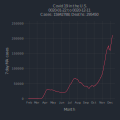

In [67]:

g = Gadfly.plot(ustotal, x=:date, y=:macases7,  
Gadfly.Geom.line,
    Gadfly.Scale.y_continuous(minvalue=0,format=:plain),
    Guide.XLabel("Month"),
    Guide.YLabel("7 day MA cases"),
    Guide.Title(tit))

g

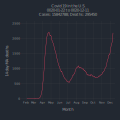

In [68]:
g = Gadfly.plot(ustotal, x=:date, y=:madeaths14, 
    Gadfly.Geom.line,
    Gadfly.Scale.y_continuous(minvalue=0,format=:plain),
    Guide.XLabel("Month"),
    Guide.YLabel("14 day MA deaths"),
    Guide.Title(tit))

g


Consider an alternative moving average function adapted from the package RollingFunctions. It's generally preferable to reuse rather than build from scratch.

In [69]:
function masm_2(vec,win)
    return(cat(fill(missing,win-1),RollingFunctions.rollmean(vec,win),dims=1))
end

pr(2)

Check.

In [70]:
print(last(DataFrame(macases14_1=round.(masm_2(ustotal.dailycases,14);digits=0),macases14_2=ustotal.macases14),14))

pr(2)

14×2 DataFrame
│ Row │ macases14_1 │ macases14_2 │
│     │ Float64?    │ Float64?    │
├─────┼─────────────┼─────────────┤
│ 1   │ 166224.0    │ 166224.0    │
│ 2   │ 166417.0    │ 166417.0    │
│ 3   │ 166419.0    │ 166419.0    │
│ 4   │ 167852.0    │ 167852.0    │
│ 5   │ 169966.0    │ 169966.0    │
│ 6   │ 172083.0    │ 172083.0    │
│ 7   │ 174391.0    │ 174391.0    │
│ 8   │ 176947.0    │ 176947.0    │
│ 9   │ 179294.0    │ 179294.0    │
│ 10  │ 180788.0    │ 180788.0    │
│ 11  │ 183852.0    │ 183852.0    │
│ 12  │ 186708.0    │ 186708.0    │
│ 13  │ 194836.0    │ 194836.0    │
│ 14  │ 196712.0    │ 196712.0    │



That's it for now. Next time I'll explore interoperating Julia with Python and R.